In [163]:
import os
import sys
import json

sys.path.append('..')

from tqdm import tqdm

import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_absolute_error, balanced_accuracy_score
from imblearn.over_sampling import SMOTENC

import matplotlib.pyplot as plt
import seaborn as sns

from utils import direct_train_test, read_csv_non_utf, count_parameters, test_thresholds
from custom_metrics import *

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

In [3]:
# Reading in the mammal dataset, for some basic model testing
data = read_csv_non_utf(ben_lop_path)
data.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


In [32]:
# Preprocessing and splitting into train/test sets - for the DL model
X_train, y_train, X_test, y_test = direct_train_test(data, train_size = 0.7, task = 'joint', 
                                                     already_pp = False, dataset = 'mammals')

#  subsetting out training instances w/very large response ratios
largest_rr = 3

train_mask = (y_train['ratio'] <= largest_rr)
X_train, y_train = X_train[train_mask], y_train[train_mask]

# Deep learning-based hurdle

In [33]:
# A basic DL model which couples the two models in the hurdle - shared feature extraction,
#  but separate ANN heads for predicting local extirpation vs. a continuous RR
class NeuralHurdle(nn.Module):
    def __init__(self, num_features, num_hidden_neurons = 128):
        super().__init__()
        self.feature_extraction = nn.Sequential(nn.Linear(num_features, num_hidden_neurons),
                                                nn.ReLU(),
                                                nn.Linear(num_hidden_neurons, num_hidden_neurons),
                                                nn.ReLU())

        self.zero_head = nn.Sequential(nn.Linear(num_hidden_neurons, 1), 
                                       nn.Sigmoid())
        self.nonzero_head = nn.Linear(num_hidden_neurons, 1)

    def forward(self, x):
        features = self.feature_extraction(x)

        prob_extirp = self.zero_head(features)
        
        raw_rr = self.nonzero_head(features)
        rr = raw_rr.square()
        
        return rr, prob_extirp

    def predict(self, x, extirp_thresh = 0.5):
        rr, prob_extirp = self.forward(x)
        y_pred = (prob_extirp.cpu() < extirp_thresh).int() * rr.cpu()

        return y_pred

In [34]:
# A custom dataset object to handle our data
class WrapperDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        predictors = self.X.iloc[idx, : ].values
        response = self.y.iloc[idx, : ].values

        predictors, response = torch.from_numpy(predictors).float(), torch.from_numpy(response).float()
        
        return predictors, response

    def num_features(self):
        return len(self.X.columns)

In [35]:
# Tossing the data into the wrapper dataset
train_data = WrapperDataset(X_train, y_train)
test_data = WrapperDataset(X_test, y_test)

train_dataloader = DataLoader(train_data, batch_size = 128, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 128, shuffle = True)

In [36]:
# Getting device, looking specifically for Mac's MPS backend 
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

# Setting up model
neural_hurdle = NeuralHurdle(num_features = train_data.num_features(), num_hidden_neurons = 512).to(device)
print(f'Model has {count_parameters(neural_hurdle)} parameters in total')

# Getting device, looking specifically for Mac's MPS backend 
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

# Loss functions and optimizer
zero_loss = nn.BCELoss()
nonzero_loss = nn.MSELoss()

optimizer = torch.optim.Adam(neural_hurdle.parameters())

Model has 268290 parameters in total


In [37]:
# Trying a basic training loop over a simple train/test split of the mammal dataset
num_epochs = 250
losses = []

#  main model training
neural_hurdle.train()
for e in tqdm(range(num_epochs)):
    for batch, (X, y) in enumerate(train_dataloader):
        #  moving data to device
        X, y = X.to(device), y.to(device)
        
        #  making a prediction + calculating loss
        rr, prob_extirp = neural_hurdle(X)
        rr, prob_extirp = rr.reshape(-1), prob_extirp.reshape(-1)

        nz_loss = nonzero_loss(rr, y[ : , 0])
        z_loss = zero_loss(prob_extirp, y[ : , 1])
        losses.append([nz_loss.item(), z_loss.item()])
        
        loss = nz_loss + z_loss

        #  backpropogation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|████████████████████████████████████████████████████████████████████████| 250/250 [00:28<00:00,  8.91it/s]


In [38]:
# Predicting on the full training set
with torch.no_grad():
    pred = []
    actual = []
    
    for X, y in train_dataloader:
        X = X.to(device)
        y_pred = neural_hurdle(X)[1].cpu().tolist()
        
        pred += y_pred
        actual += y[ : , 1].tolist()

pred, actual = np.array(pred), np.array(actual)

#  tuning the threshold for local extirpation model
opt_thresh, _ = test_thresholds(pred, actual, precision = 0.05)
opt_thresh = round(opt_thresh, 2)

print(f'Optimal threshold from train set: {opt_thresh}')

Optimal threshold from train set: 0.15


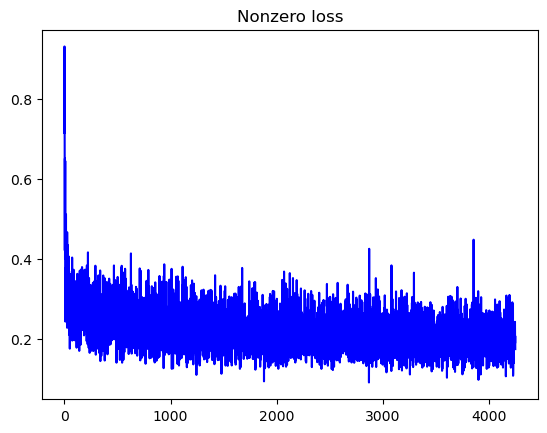

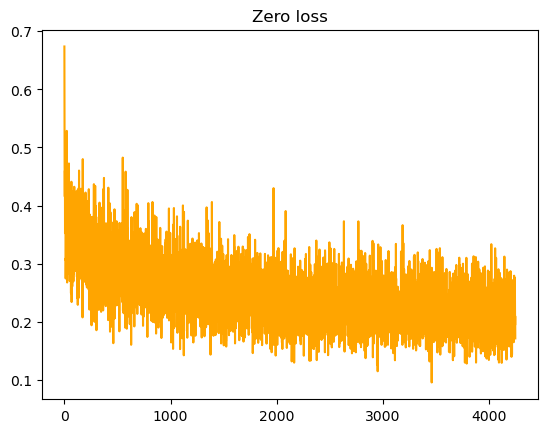

In [39]:
# Plotting the progression of the two loss components
losses = np.array(losses)

plt.plot(losses[ : , 0], color = 'blue')
plt.title('Nonzero loss')
plt.show()

plt.plot(losses[ : , 1], color = 'orange')
plt.title('Zero loss')
plt.show()

In [47]:
# Evaluating the DL hurdle-style model
neural_hurdle.eval()

#  getting all predictions for the test set
with torch.no_grad():
    pred = []
    actual = []
    
    for X, y in test_dataloader:
        X = X.to(device)
        y_pred = neural_hurdle.predict(X, extirp_thresh = opt_thresh).cpu().tolist()
        
        pred += y_pred
        actual += y.tolist()

pred, actual = np.array(pred).reshape(-1), np.array(actual)

#  computing metrics
actual_rr = actual[ : , 0].reshape(-1)

mape = mean_absolute_percent_error_tau(actual_rr, pred, tau = 0.05)
ba = balanced_accuracy_DI_cats(actual_rr, pred, neighborhood = 0.05)
mae = mean_absolute_error(actual_rr, pred)
mae_01 = mean_absolute_error_range(actual_rr, pred, lower_bound = 0, upper_bound = 1)[0]

#  displaying test metric values
print('MAPE_0.05:', round(mape * 100, 3))
print('BA_0.05:', round(ba * 100, 3))
print('MAE:', round(mae, 3))
print('MAE 0-1:', round(mae_01, 3))

MAPE_0.05: 59.006
BA_0.05: 40.294
MAE: 0.877
MAE 0-1: 0.236


In [55]:
# Taking a look at the balanced accuracy for JUST the local extirpation model
actual_extirp = actual[ : , 1].reshape(-1)
pred_extirp = (pred == 0).astype(int)

ba_extirp = balanced_accuracy_score(actual_extirp, pred_extirp)
print('BA extirp:', round(ba_extirp, 3))

BA extirp: 0.706


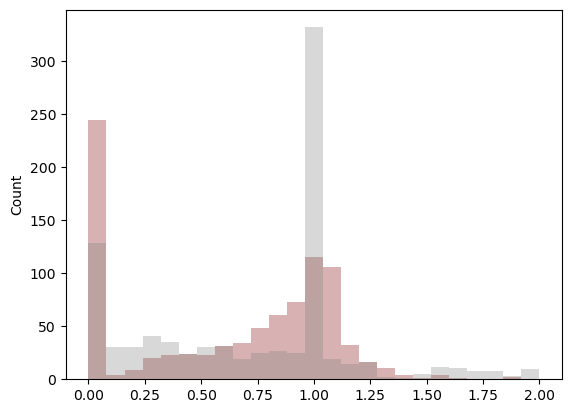

In [43]:
# Looking at histogram of RRs - pred vs actual
max_val = 2

max_mask = ((actual <= max_val) & (actual >= 0))
actual_maxed = actual[max_mask].reshape(-1)
pred_maxed = pred[max_mask].reshape(-1)


sns.histplot(x = pred_maxed, stat = 'count', kde = False, legend = False, bins = 25, 
             color = 'maroon', zorder = 100, alpha = 0.3, ec = None, binrange = (0, max_val))
sns.histplot(x = actual_maxed, stat = 'count', kde = False, legend = False, bins = 25, 
             color = 'grey', zorder = 100, alpha = 0.3, ec = None, binrange = (0, max_val))

plt.show()

# Stacked generalization

In [148]:
# Potential for a neural model on end of stacked generalization pipeline?
class NeuralStackedGeneralizer(nn.Module):
    def __init__(self, num_input_models, num_features, num_hidden_neurons = 128):
        super().__init__()
        self.generalizer = nn.Sequential(nn.Linear(num_input_models + num_features, num_hidden_neurons),
                                         nn.ReLU(),
                                         nn.Linear(num_hidden_neurons, num_hidden_neurons),
                                         nn.ReLU(), 
                                         nn.Linear(num_hidden_neurons, num_input_models))

    def forward(self, model_outputs, features, return_weights = False):
        #  stack model outputs + features into a single matrix
        x = torch.cat((model_outputs, features), dim = 1)
        
        #  predict model weights for each sample (original features + model predictions)
        raw_model_weights = self.generalizer(x).square()
        model_weights = raw_model_weights.transpose(0, 1).div(raw_model_weights.sum(axis = 1)).transpose(1, 0)

        #  using the model weights to compute the final RR, as a weighted avg of model predictions
        rr = torch.mul(model_weights, model_outputs).sum(axis = 1)
        
        if return_weights:
            return rr, model_weights
        return rr

In [147]:
# Just checking that everything's working correctly here w/some toy matrices
num_models = 5
num_features = 8
N = 10

model_outputs = torch.rand(N, num_models)
features = torch.rand(N, num_features)

nsg = NeuralStackedGeneralizer(num_models, num_features, 128)
rr = nsg(model_outputs, features, False)

rr.shape

torch.Size([10])

# Median vs. mean absolute error

In [44]:
f = '/Users/emiliolr/Desktop/life-hunting/mres_results/raw_predictions/pymer_hurdle_wo_rfx_mammals_5-fold_random-blocking.csv'
d = pd.read_csv(f)

for k in range(0, 5):
    d_sub = d[d['fold'] == k]

    aes = np.abs(d_sub['predicted'] - d_sub['actual'])

    print('Mean vs median AEs, overall:')
    print(np.mean(aes))
    print(np.median(aes))
    print()

    lower_bound, upper_bound = 0, 1

    bound_mask = (d_sub['actual'] >= lower_bound) & (d_sub['actual'] <= upper_bound)
    y_true_sub = d_sub['actual'][bound_mask]
    y_pred_sub = d_sub['predicted'][bound_mask]

    print('Mean vs median AEs, 0-1 range:')
    print(np.mean(np.abs(y_pred_sub - y_true_sub)))
    print(np.median(np.abs(y_pred_sub - y_true_sub)))
    print('---')

Mean vs median AEs, overall:
0.8904571372323528
0.3096538440735773

Mean vs median AEs, 0-1 range:
0.33241320309630923
0.2475833870825495
---
Mean vs median AEs, overall:
0.9396920076951054
0.31029616719648573

Mean vs median AEs, 0-1 range:
0.32671652422771424
0.2364694181252425
---
Mean vs median AEs, overall:
0.8488565852078693
0.29422363727097933

Mean vs median AEs, 0-1 range:
0.32642724282905555
0.23131495212250486
---
Mean vs median AEs, overall:
0.7737067842936436
0.3484616765629174

Mean vs median AEs, 0-1 range:
0.3579765109843509
0.2734272856567567
---
Mean vs median AEs, overall:
1.0039194560360574
0.3783928627456551

Mean vs median AEs, 0-1 range:
0.342042949112395
0.27017621378330264
---


# SMOTE for fixing class imbalance problems

In [221]:
# Oversampling the minority class using the SMOTE algorithm - messes w/the normalization, so this should
#  be done BEFORE preprocessing steps
X_sub = data[['TravTime', 'DistKm', 'Reserve']].copy(deep = True)
X_sub['Reserve'] = (X_sub['Reserve'] == 'Yes').astype(int)
y_sub = (data['ratio'] == 0).copy(deep = True).astype(int)

smote = SMOTENC(categorical_features = ['Reserve'], random_state = 1693)
X_res, y_res = smote.fit_resample(X_sub, y_sub)